<a href="https://colab.research.google.com/github/LuFernandez/imagaynes/blob/master/Restauracion_imgs/restore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP - Restauración de Imágenes
###Ezequiel Vijande
###Lucero Guadalupe Fernandez

###Imports a utilizar

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

####Cargamos imágenes

In [4]:
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/Restauracion_imgs/pic/lenna.png
clear_output()

####mostramos imagen original y definimos funciones a utilizar

In [113]:
#definimos la funcion del filtro: recibe el tamaño del kernel,
#y la imagen sobre la que se aplica el filtro, se usa filtro promediador
def ApplyBlur(img, k_size=3): #lowpass
  kernel = np.full((k_size, k_size), 1)/(k_size**2)
  #kernel = ExpandKernel(kernel, img.shape)
  #G = np.fft.fft2(kernel)*np.fft.fft2(img[:,:,0])
  #G = np.fft.fftshift(G)
  #return np.real(np.fft.ifftshift(np.fft.ifft2(G))), kernel
  return cv2.filter2D(img,-1,kernel), kernel

def ApplyNoise(img):
  row,col,ch = img.shape
  mean = 0
  std = 15
  gauss = np.random.normal(mean,std,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = img + gauss.astype(np.int16)
  return noisy.astype(np.int16)

#ploteamos secuencia
def MakeSubplot(img,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)

##Inverse Filter

###Blur

In [123]:
def ExpandKernel(kernel, size):
  delta = np.zeros((size[0], size[1]), dtype=float)
  delta[size[0]//2,size[1]//2] = 1
  return cv2.filter2D(delta, -1, kernel)


def ApplyInverseFilter(degraded, kernel_og):
  kernel = ExpandKernel(kernel_og, degraded.shape)
  H = np.fft.fft2(kernel)
  G = np.fft.fft2(degraded[:,:,0])
  R = np.fft.fftshift(G/H)
  return np.real(np.fft.ifftshift(np.fft.ifft2(R))) 

[[-1042.68320818    96.53268506   -71.35405238 ...  -383.42644288
    609.52066739   356.26402471]
 [ -101.49681443   521.68416525  -624.74972183 ...  -120.81465649
  -1127.51406236   -96.66074879]
 [   84.89502339  -990.96752695   395.68589677 ...  -104.30647281
   -487.19564881  -717.42499655]
 ...
 [  154.73893463 -1411.84511517   154.78854629 ...   117.21963584
     28.55206521   170.48189386]
 [  218.00062478   -66.71509284  -104.28579415 ...  -125.79749335
   -549.72545012  -223.05391125]
 [ -143.04786098  1141.41543653  -252.40246588 ...  -115.03320367
    -16.03360324   406.98592855]]


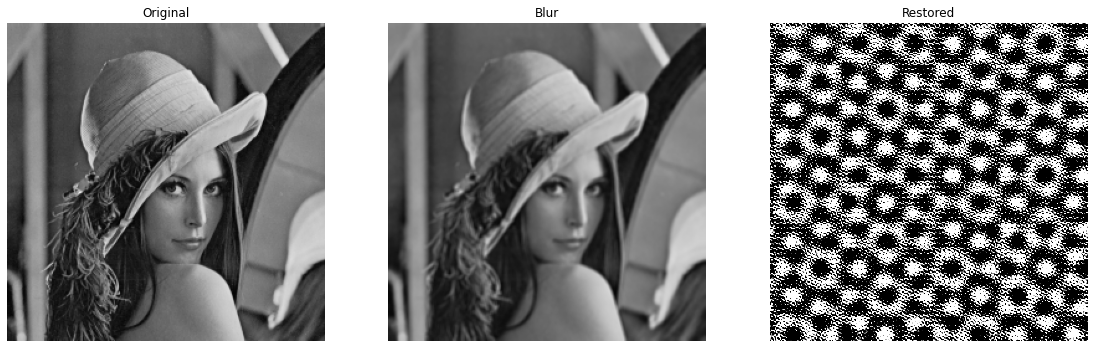

In [124]:
#Original
lenna = cv2.imread('lenna.png')
#
degraded, kernel = ApplyBlur(lenna)
restored = ApplyInverseFilter(degraded, kernel)
print(restored)
fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(degraded,fig_a,1,3,2,title="Blur")
MakeSubplot(restored,fig_a,1,3,3,title="Restored")

In [ ]:
#Original
lenna = cv2.imread('lenna.png')

degraded = ApplyNoise(ApplyBlur(lenna))

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(degraded,fig_a,1,3,2,title="Blur & Noise")

